In [5]:
cd ..


/Users/samweiss/src/ibotta_uplift


## Introduction 

This notebook will go over optimization of a single response variable using the IbottaUplift Framework. It will go over:

1. Hypothetical Problem and The data Generating Process

2. Building / Gridsearching an uplift model 

3. Evaluating Model with out-of-sample ERUPT metric

4. Assigning Optimal Treatments for new observations 

In [28]:
import numpy as np
import pandas as pd

from dataset.data_simulation import get_simple_uplift_data
from ibotta_uplift.ibotta_uplift import IbottaUplift
from ggplot import *

### Data Generating Process 

Imagine we are data scientists working for a startup that would like to be more growth oriented but in an efficient way. 

As a tactic to increase user activity the company gives all users a potentially expensive treatment. In order to reduce costs we were assigned the task of using data to find a subset of users that should continue receiving the costly treatment while continue increasing revenue / growth. 

The company would rather have increase in revenue even if it decreased overall profitiability. However, we do not know the relative tradeoff of growth in revenue vs profitibility is. 

If we knew the relative tradeoffs we could create a new variable $y_new = (1-a)*revenue - a*costs$ and maximize that as a normal uplift problem. Since we don't know the value of $a$ we will have to calculate the tradeoffs. 

This problem therefore entails both finding users and evaluating tradeoffs among different response variables. 

We are given some explanatory variables for users $x$, a random treatment of whether a users recieved marketing campaign or not $t$, and response variable of profitibility $y$. 

We can use  IbottaUplift to find the tradeoff between increases in revenue vs the increase in costs. Once we have found a suitable tradeoff we can then use the model to target users that should recieve the treatment given our new objectives.

Below is the data generating process of the data we have. 

$$x_1  ∼ runif(0,1)$$
$$x_2 ∼ runif(0,1)$$
$$e_1 ∼ rnorm(0,1)$$
$$e_2 ∼ rnorm(0,1)$$
$$t ∼ rbinom(.5)$$

$$revenue = x_1*t + e_1$$
$$costs = x_2*t + e_2$$

$$profit = revenue - costs $$



In [29]:
y, x, t = get_simple_uplift_data(10000)

y = pd.DataFrame(y)
y.columns = ['revenue','cost', 'noise']
y['profit'] = y['revenue'] - y['cost']

### Model Building / Gridsearch
After instantiating the IbottaUplift class the `.fit` function will build the model.

This builds and runs grisdesarch for a keras neural network model minimizing mean squared error. The user can input customer parameters as necessary. 


In [30]:
uplift_model = IbottaUplift()
param_grid = dict(num_nodes=[8], dropout=[.1, .5], activation=[
                          'relu'], num_layers=[1, 2], epochs=[25], batch_size=[30])


uplift_model.fit(x, y, t.reshape(-1,1), param_grid = param_grid, n_jobs = 1)

/Users/samweiss/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Evaluating Tradeoffs using out-of-sample ERUPT Curves
Using the test dataset IbottaUplift will then evaluate the model using the ERUPT metrics with different objective weights with the `get_erupt_curves` function. 

Each objective weights will consist of an array equal to the number of responses. With these weights it calculates a new variable based on predictions to maximize $y_{new} = weight_0*\hat{y_0} + weight_1*\hat{y_1} + ... + weight_{num responses}*\hat{y_{num responses}}$. 

Varying the objective weights allows us to see what happens when we increase the focus of model from a revenue maximizing problem to a cost minimizing problem. 



The `get_erupt_curves` function outputs two dataframes:

1) The first show the ERUPT metric and standard deviation for all response variables given a set of model weights. In this example the weights are set up to go from a cost minimizing to a revenue maximimization objective. We see both costs and revenue go up but at different rates. Profit is maximized when the revenue weight is .5 and cost weight is .5. Finally we can also see the noise response variable is not effected as expected. 


2) The second pandas df shows the distribution of treatments under the optimal assignment for a set of objective weights. In this example we can see those assigned the treatment increase as we weight the objective function towards to be more revenue maximization.




/Users/samweiss/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


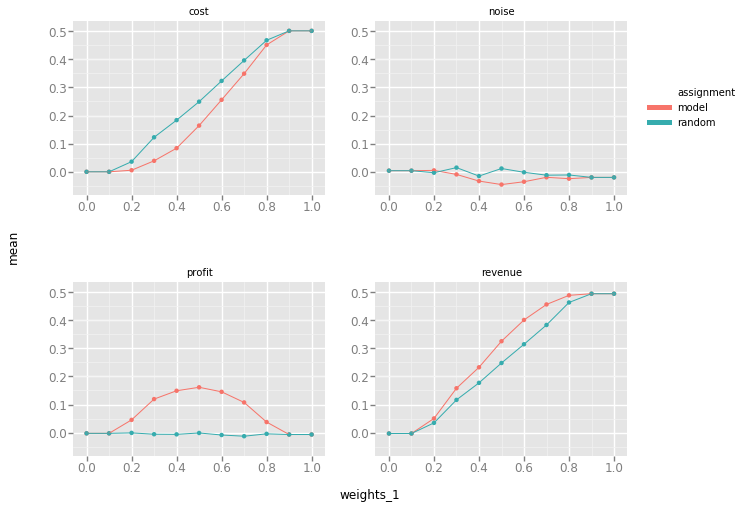

<ggplot: (-9223372036547644756)>

In [12]:
erupt_curves, dists = uplift_model.get_erupt_curves()

dists['weights_1'] = [np.float(x.split(',')[0]) for x in dists['weights']]
erupt_curves['weights_1'] = [np.float(x.split(',')[0]) for x in erupt_curves['weights']]

ggplot(aes(x='weights_1', y='mean', group = 'assignment', colour = 'assignment'), data=erupt_curves) +\
    geom_line()+\
    geom_point()+facet_wrap("response_var_names")

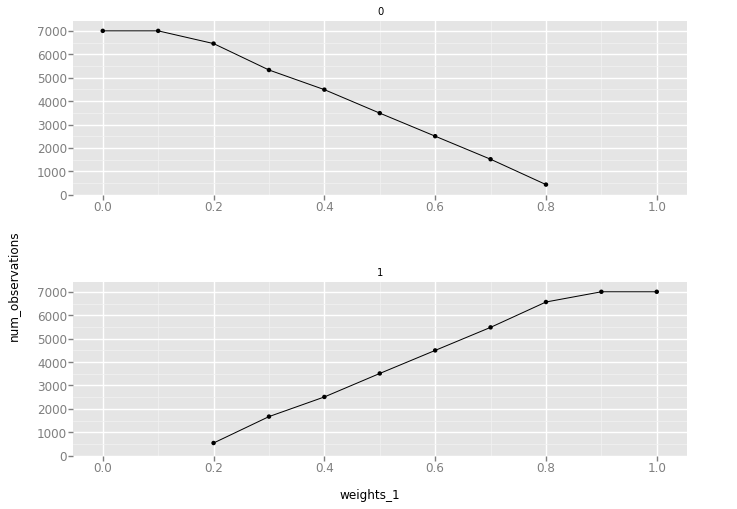

<ggplot: (-9223372036547264501)>

In [13]:
ggplot(aes(x='weights_1', y='num_observations'), data=dists) +\
    geom_line()+\
    geom_point()+facet_wrap('tmt')

### Assigning Optimal Treatments for new observations
After building and evaluating an uplift model the modeller may deem it worthy of production. To assign new users the optimal treatment one can use the `predict_optimal_treatments` function to do so below.



In [33]:
#generate 5 new observation
_, x_new ,_  = get_simple_uplift_data(5)
uplift_model.predict_optimal_treatments(x_new, weights = np.array([1,-.9,0,0]).reshape(1,-1))

/Users/samweiss/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[1],
       [0],
       [0],
       [1],
       [1]])

In [31]:
erupt_curves

,mean,std,response_var_names,weights,assignment,weights_1
0,-0.003280,0.001675,revenue,"0.0,-1.0,0.0,0.0",model,0.0
1,-0.000570,0.001673,cost,"0.0,-1.0,0.0,0.0",model,0.0
2,0.003446,0.016896,noise,"0.0,-1.0,0.0,0.0",model,0.0
3,-0.002710,0.002364,profit,"0.0,-1.0,0.0,0.0",model,0.0
0,-0.003280,0.001675,revenue,"0.0,-1.0,0.0,0.0",random,0.0
1,-0.000570,0.001673,cost,"0.0,-1.0,0.0,0.0",random,0.0
2,0.003446,0.016896,noise,"0.0,-1.0,0.0,0.0",random,0.0
3,-0.002710,0.002364,profit,"0.0,-1.0,0.0,0.0",random,0.0
0,-0.003280,0.001675,revenue,"0.1,-0.9,0.0,0.0",model,0.1
1,-0.000570,0.001673,cost,"0.1,-0.9,0.0,0.0",model,0.1
